In [120]:
import datetime
import glob
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

fink_event_files = glob.glob("../../alerted_2425_events/*.csv")

In [121]:
fname_alerce = os.path.join(
    "..",
    "..",
    "ALeRCE_probabilities",
    "ALeRCE_classifiers_{}.csv".format(df["i:objectId"][0]),
)
fname_alerce
df2 = pd.read_csv(fname_alerce)

In [122]:
df2

,classifier_name,classifier_version,class_name,probability,ranking
0,lc_classifier,lc_classifier_1.1.13,SNIa,0.132000,4
1,stamp_classifier,stamp_classifier_1.0.4,SN,0.852170,1
2,lc_classifier,lc_classifier_1.1.13,SNIbc,0.224000,2
3,stamp_classifier,stamp_classifier_1.0.4,AGN,0.032664,4
4,lc_classifier,lc_classifier_1.1.13,SNII,0.446000,1
5,stamp_classifier,stamp_classifier_1.0.4,VS,0.048682,2
6,lc_classifier,lc_classifier_1.1.13,SLSN,0.198000,3
7,stamp_classifier,stamp_classifier_1.0.4,asteroid,0.026481,5
8,lc_classifier,lc_classifier_1.1.13,QSO,0.000000,14
9,stamp_classifier,stamp_classifier_1.0.4,bogus,0.040002,3


In [ ]:
probabilities = {}
from alerce.core import Alerce

alerce = Alerce()
for fname in fink_event_files:
    df = pd.read_csv(fname)
    alerce_file = os.path.join(
        "..",
        "..",
        "ALeRCE_probabilities",
        "ALeRCE_classifiers_{}.csv".format(df["i:objectId"][0]),
    )
    try:
        object_id = df["i:objectId"][0]
        prob_a = alerce.query_probabilities(object_id)
        prob_pd = pd.DataFrame.from_dict(prob_a)
        stochastic_bhrf_rank = prob_pd.loc[
            prob_pd["classifier_name"] == "lc_classifier_BHRF_forced_phot_stochastic"
        ]

        probabilities[df["i:objectId"][0]] = {
            "fink": df["d:mulens"].array[0],
            "alerce": stochastic_bhrf_rank[
                stochastic_bhrf_rank["class_name"] == "Microlensing"
            ].iloc[0]["probability"],
        }
    except Exception as e:
        print("ALeRCE unavailable {}".format(e))
        probabilities[df["i:objectId"][0]] = {"fink": df["d:mulens"].array[0]}

In [ ]:
probabilities
'alerce' in probabilities[entry]
probabilities[entry]["alerce"]

In [174]:
alerce_values = []
fink_values = []

for entry in probabilities:
    if 'alerce' in probabilities[entry]:
        alerce_values.append(probabilities[entry]["alerce"])
    if probabilities[entry]["fink"]>0.:
        fink_values.append(probabilities[entry]["fink"])


/home/mpgh/astro_1_2024/astro1_env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (37). n_quantiles is set to n_samples.
  warnings.warn(
/home/mpgh/astro_1_2024/astro1_env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (32). n_quantiles is set to n_samples.
  warnings.warn(


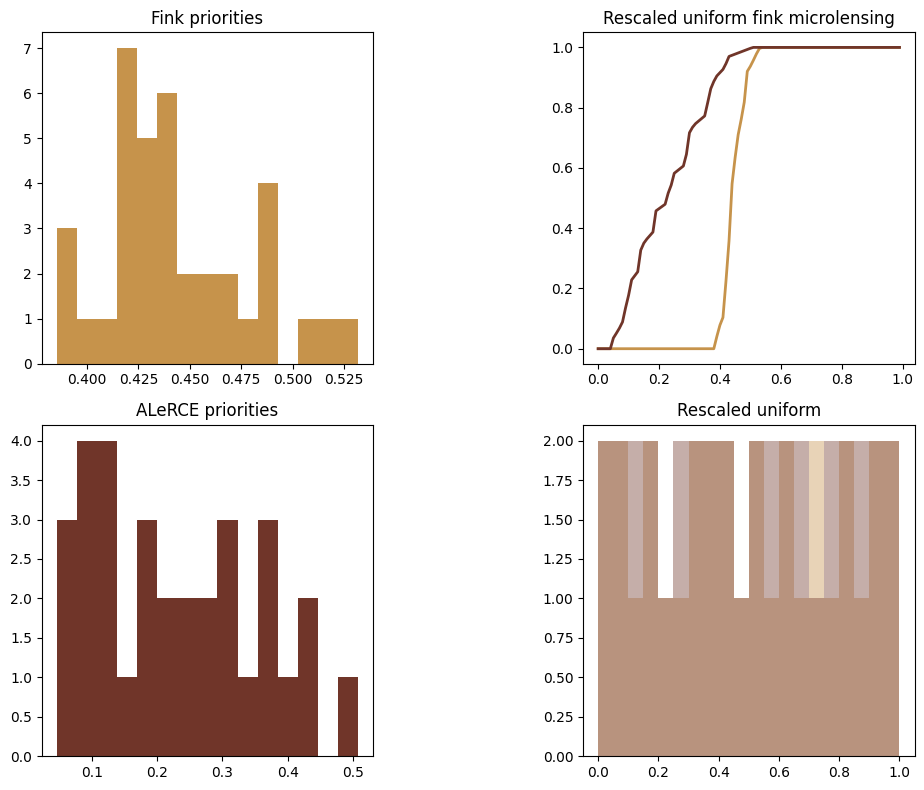

In [183]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer

dist1 = np.array(fink_values)
dist2 = np.array(alerce_values)
# Initialize QuantileTransformers to map to a normal distribution
qt1 = QuantileTransformer(output_distribution="uniform", random_state=0)
qt2 = QuantileTransformer(output_distribution="uniform", random_state=0)

# Fit and transform the distributions
transformed1 = qt1.fit_transform(dist1.reshape(-1, 1)).flatten()
transformed2 = qt2.fit_transform(dist2.reshape(-1, 1)).flatten()

# Plotting setup
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].set_box_aspect(aspect=1)

axs[0, 0].hist(dist1, bins=15, color="#c6934b")
axs[0, 0].set_title("Fink priorities")

#test_arr = np.linspace(0, 1, 100)
transformeda = qt1.transform(test_arr.reshape(-1, 1))
transformedb = qt2.transform(test_arr.reshape(-1, 1))

axs[0, 1].set_box_aspect(aspect=1)
axs[0, 1].plot(test_arr, transformeda, lw=2, color="#c6934b")
axs[0, 1].plot(test_arr, transformedb, lw=2, color="#703529")

#axs[0, 1].hist(transformed1, bins=30, color="#283d70")
axs[0, 1].set_title("Rescaled uniform fink microlensing")

# Original dist2 (Uniform)
axs[1, 0].set_box_aspect(aspect=1)
axs[1, 0].hist(dist2, bins=15, color="#703529")
axs[1, 0].set_title("ALeRCE priorities")

# Transformed dist2 (Normal)
axs[1, 1].set_box_aspect(aspect=1)
axs[1, 1].hist(transformed2, bins=20, color="#c6934b",alpha=0.4)
axs[1, 1].hist(transformed1, bins=20, color="#703529",alpha=0.4)
axs[1, 1].set_title("Rescaled uniform")

# Adjust layout
plt.tight_layout()
plt.show()

# 2e3546,#c6934b,#703529

In [191]:
alerce_values = []
fink_values = []

for entry in probabilities:
    if 'alerce' in probabilities[entry]:
        alerce_values.append(probabilities[entry]["alerce"])
    else:
        alerce_values.append(0)
    if probabilities[entry]["fink"]>0.:
        fink_values.append(probabilities[entry]["fink"])
    else:
        fink_values.append(0)
        

In [197]:
np.argsort(fink_values),np.argsort(alerce_values)

(array([  0, 107, 106, 105, 104, 102, 101, 100,  98,  97,  96,  95,  94,
         93,  92,  89,  88,  85,  84,  83,  82,  81,  80,  79,  77,  75,
         72,  71,  70,  69, 108,  68, 109, 113, 150, 149, 148, 147, 146,
        145, 144, 142, 141, 140, 139, 138, 134, 133, 132, 131, 130, 128,
        127, 125, 123, 122, 120, 119, 118, 117, 116, 115, 114, 111,  66,
         76,  64,  39,  38,  37,  36,  35,  33,  65,  31,  30,  29,  28,
         27,  26,  25,  22,  21,  20,  19,  18,  16,  14,  13,  12,  11,
          9,   8,   3,   2,   1,  40,  41,  32,  56,  63,  62,  61,  60,
         59,  58,  57,  42,  55,  51,  50, 152,  49,  46,  44,  47,  34,
         90, 112,  78,  52,   6,  45, 126,  86, 151,  87, 136,  73, 103,
        121,  67, 137, 143, 129,  15,   7,   4, 124,  54,   5, 110,  48,
        135,  23,  53,  74,  24,  43,  10,  17,  91,  99]),
 array([  0, 105, 104, 103, 102, 100,  99,  98,  97,  96,  95,  94,  93,
         92,  91, 106,  90,  87,  86,  84,  83,  81,  80,  79,  